### Part 1 - Take Home Exercises
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/大學/大五上/資料探勘與應用/DMlab2

/content/drive/MyDrive/大學/大五上/資料探勘與應用/DMlab2


In [3]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install gensim --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Table of Contents

1. Data preparation
    - Load data
        - **Exercise 1**
    - Save data
    - Exploratory data analysis (EDA)
2. Feature engineering
    - **Exercise 2**
3. Model
    - Decision Trees
4. Results evaluation
    - **Exercise 3**
    - **Exercise 4**
    - **Exercise 5**
5. Other things you can try
6. Deep Learning
    - Prepare data (X, y)
    - Deal with categorical label (y)
    - Build model
    - Train
    - Predict on testing data
        - **Exercise 6**
7. Word to Vector
    - Prepare training corpus
    - Training our model
    - Generating word vector (embeddings)
    - Using a pre-trained w2v model
    - king + woman - man = ?
        - **Exercise 7**
8. Clustering
9. High-dimension Visualization
    - Prepare visualizing target
    - Plot using t-SNE (2-dimension)
        - **Exercise 8**
---

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embedding and other deep information retrieval approaches.

![pic0](pics/pic0.png)

---

####  **Exercise 1 :** 

Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)

-------------

In [5]:
import pandas as pd

### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [6]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [7]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [8]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [9]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px

#learn the vocabulary and return document-term matrix
count_vect = CountVectorizer()
train_df_counts = count_vect.fit_transform(train_df.text) 

#TOP30 Term Frequencies (Train data)
train_term_frequencies = []
train_counts_arr = train_df_counts.sum(axis=0).tolist()[0]
for j in range(0, train_df_counts.shape[1]):
    train_term_frequencies.append(train_counts_arr[j])

freqDF = pd.DataFrame(count_vect.get_feature_names_out(), columns= ['terms'])
freqDF['frequency'] = train_term_frequencies

# sort
freqDF = freqDF.sort_values(by=['frequency'], ascending=False)

fig = px.bar(freqDF[:30], x=freqDF['terms'][:30], y=freqDF['frequency'][:30], title  = "TOP30 Term Frequencies (Train data)", labels = {'x':'Terms', 'y':'Frequencies'})

fig.show()

In [11]:
#learn the vocabulary and return document-term matrix
count_vect = CountVectorizer()
test_df_counts = count_vect.fit_transform(test_df.text) 

#TOP30 Term Frequencies (Test data)
test_term_frequencies = []
test_counts_arr = test_df_counts.sum(axis=0).tolist()[0]
for j in range(0, test_df_counts.shape[1]):
    test_term_frequencies.append(test_counts_arr[j])

freqDF = pd.DataFrame(count_vect.get_feature_names_out(), columns= ['terms'])
freqDF['frequency'] = test_term_frequencies

# sort
freqDF = freqDF.sort_values(by=['frequency'], ascending=False)

fig = px.bar(freqDF[:30], x=freqDF['terms'][:30], y=freqDF['frequency'][:30], title  = "TOP30 Term Frequencies (Test data)", labels = {'x':'Terms', 'y':'Frequencies'})

fig.show()

####  **Exercise 2 :** 

Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

-------------

In [12]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# build analyzers (TF-IDF)
TFIDF_Vect = TfidfVectorizer() 

# apply analyzer to training data
TFIDF_Vect.fit(train_df['text'])

train_data_TFIDF_features = TFIDF_Vect.transform(train_df['text'])

## check dimension
train_data_TFIDF_features.shape

(3613, 10115)

In [13]:
train_data_TFIDF_features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# observe some feature names
feature_names_TFIDF = TFIDF_Vect.get_feature_names_out()
feature_names_TFIDF[100:110]

array(['2k17', '2much', '2nd', '30', '300', '301', '30am', '30pm', '30s',
       '31'], dtype=object)

####  **Exercise 3 :** 

Can you interpret the results above? What do they mean?

-------------

In [15]:
from sklearn.tree import DecisionTreeClassifier

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [16]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['fear', 'anger', 'fear', 'anger', 'anger', 'anger', 'anger',
       'sadness', 'fear', 'anger'], dtype=object)

Now we will check the results of our model's performance

In [17]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))


training accuracy: 0.98
testing accuracy: 0.69


In [18]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.61      0.74      0.67        84
        fear       0.75      0.70      0.72       110
         joy       0.72      0.68      0.70        79
     sadness       0.67      0.61      0.64        74

    accuracy                           0.69       347
   macro avg       0.69      0.68      0.68       347
weighted avg       0.69      0.69      0.69       347



In [19]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[62  6  7  9]
 [16 77  9  8]
 [10 10 54  5]
 [14 10  5 45]]


In [20]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

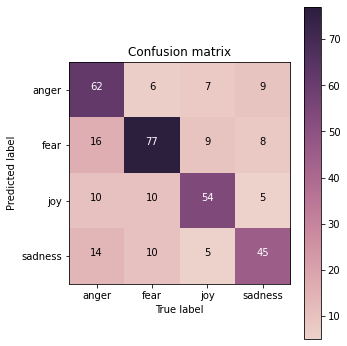

In [21]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

Ans:

- Total "anger": 84(62+6+7+9) 
    - 62 (correct prediction)
    -  6 (Mispredicted as "fear")
    -  7 (Mispredicted as "joy")
    -  9 (Mispredicted as "sadness")
- Total "fear": 110(16+77+9+8) 
    - 16 (Mispredicted as "anger")
    - 77 (correct prediction)
    -  9 (Mispredicted as "joy")
    -  8 (Mispredicted as "sadness")
- Total "joy": 79(10+10+54+5) 
    - 10 (Mispredicted as "anger")
    - 10 (Mispredicted as "fear")
    - 54 (correct prediction)
    -  5 (Mispredicted as "sadness")
- Total "sadness": 74(14+10+5+45) 
    - 14 (Mispredicted as "anger")
    - 10 (Mispredicted as "fear")
    -  5 (Mispredicted as "joy")
    - 45 (correct prediction)

####  **Exercise 4 :** 

Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

-------------

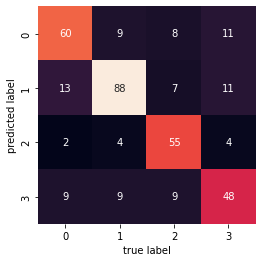

In [22]:
from sklearn.naive_bayes import MultinomialNB

## training!
clf = MultinomialNB()
clf = clf.fit(X_train, y_train)

## predict!
y_test_pred = clf.predict(X_test)

#confusion_matrix plot
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_test, y_test_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

####  **Exercise 5 :** 

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

-------------

####  **Exercise 6 :** 

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?

<table><tr>
    <td><img src="pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

-------------

- Prepare data (X, y)

In [23]:
import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


- Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves. 

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [24]:
## deal with label (string -> one-hot)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 1188       fear
1570       fear
2410        joy
3051    sadness
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


- Build model

In [25]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


![Imgur](pics/pic2.png)

In [26]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 softmax (Softmax)           (None, 4)                 0     

- Train

In [27]:
from keras.callbacks import CSVLogger
from matplotlib import pyplot as plt

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))

print('training finish')

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning:

Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.



113/113 [==============================] - 1s 4ms/step - loss: 1.3251 - accuracy: 0.3670 - val_loss: 1.2676 - val_accuracy: 0.4957
Epoch 2/25
113/113 [==============================] - 0s 3ms/step - loss: 0.9132 - accuracy: 0.6914 - val_loss: 0.8129 - val_accuracy: 0.7176
Epoch 3/25
113/113 [==============================] - 0s 3ms/step - loss: 0.5208 - accuracy: 0.8093 - val_loss: 0.7181 - val_accuracy: 0.7032
Epoch 4/25
113/113 [==============================] - 0s 4ms/step - loss: 0.3748 - accuracy: 0.8575 - val_loss: 0.7518 - val_accuracy: 0.7089
Epoch 5/25
113/113 [==============================] - 0s 4ms/step - loss: 0.3023 - accuracy: 0.8909 - val_loss: 0.8074 - val_accuracy: 0.7032
Epoch 6/25
113/113 [==============================] - 0s 3ms/step - loss: 0.2477 - accuracy: 0.9170 - val_loss: 0.8375 - val_accuracy: 0.6974
Epoch 7/25
113/113 [==============================] - 0s 4ms/step - loss: 0.2063 - accuracy: 0.9316 - val_loss: 0.8665 - val_accuracy: 0.6916
Epoch 8/25
113/11

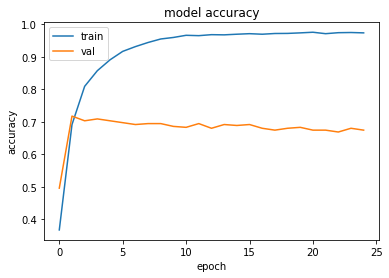

In [28]:
#plot acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

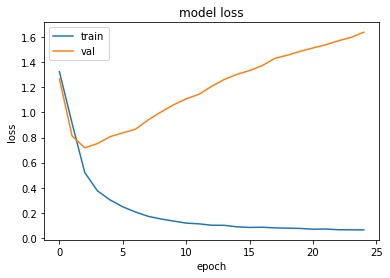

In [29]:
#plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####  **Exercise 7 :** 

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?

-------------

- Prepare training corpus

In [30]:
## check library
import gensim
nltk.download('punkt')

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,text,text_tokenized
1188,20331,Recording some more #FNAF and had to FaceTime ...,"[Recording, some, more, #, FNAF, and, had, to,..."
1570,20713,$100 says Teufel is 'reassigned' within the or...,"[$, 100, says, Teufel, is, 'reassigned, ', wit..."
2410,30406,@nw_autonate \n\n*She held the back of his sku...,"[@, nw_autonate, \n\n, *, She, held, the, back..."
3051,40224,"Way too cool to die young, way too young to di...","[Way, too, cool, to, die, young, ,, way, too, ..."
316,10316,I've always had a weird grudge against stingra...,"[I, 've, always, had, a, weird, grudge, agains..."


In [31]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['Recording', 'some', 'more', '#', 'FNAF', 'and', 'had', 'to', 'FaceTime', 'my', 'mum', 'to', 'let', 'her', 'know', 'I', 'was', 'okay', 'after', 'I', 'let', 'out', 'a', 'high', 'pitched', 'scream', '😂', '#', 'horror', '#', 'suchagirl']),
       list(['$', '100', 'says', 'Teufel', 'is', "'reassigned", "'", 'within', 'the', 'organization', 'before', 'next', 'year', ',', 'but', 'I', 'wish', 'it', 'was', 'sooner', '...', '#', 'Mets', '#', 'thirdbasecoach', '#', 'terrible', '#', 'lgm']),
       list(['@', 'nw_autonate', '\\n\\n', '*', 'She', 'held', 'the', 'back', 'of', 'his', 'skull', ',', 'smiling', 'into', 'the', 'kiss', '.', '*'])],
      dtype=object)

- Training our model

You can try to train your own model. More details: https://radimrehurek.com/gensim/models/word2vec.html

In [32]:
from gensim.models import Word2Vec

## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_epochs)

- Generating word vector (embeddings)

In [33]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([ 0.04708064,  0.09048034, -0.08091954, -0.01576735,  0.1330773 ,
       -1.2774516 ,  0.4103602 ,  1.0672914 , -0.32886878, -0.7796557 ,
       -0.52806   , -0.68263274, -0.5978767 ,  0.5505949 , -0.33866096,
       -0.67954874, -0.02388231, -0.46964478,  0.40284064, -1.3541034 ,
        0.8002063 ,  0.92597693,  0.53012365,  0.57443285,  0.1478046 ,
        0.23766989, -0.4950423 ,  0.72601986, -0.37606356,  0.08501478,
        0.55719024,  0.0308956 ,  0.56026   , -0.7571072 , -0.4775344 ,
        0.22844112, -0.1478442 , -0.22098199, -0.463971  , -0.46201637,
       -0.10586311, -0.08196509, -0.12890008,  0.3171453 ,  0.8244889 ,
       -0.1044118 , -1.0359793 ,  0.1319873 ,  0.08138683,  0.5349301 ,
        0.08638362, -0.12468227, -0.01779192, -0.36193913, -0.47831297,
       -0.57763535,  0.0628453 ,  0.3442118 ,  0.07660852,  0.03797608,
       -0.32649687, -0.18899234,  0.25223225,  0.20328833, -0.54918104,
        0.8018467 ,  0.599737  ,  0.88840365, -0.9409649 ,  0.23

In [34]:
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[('Be', 0.933788001537323),
 ('birthday', 0.9256110191345215),
 ('See', 0.9215712547302246),
 ('help', 0.9142207503318787),
 ('cats', 0.9105050563812256),
 ('bday', 0.9061558246612549),
 ('smile', 0.9053522348403931),
 ('dad', 0.9041086435317993),
 ('free', 0.9024696946144104),
 ('A4', 0.8988297581672668)]

- Using a pre-trained w2v model

Instead of training your own model ,you can use a model that has already been trained. Here, we see 2 ways of doing that:


- Download model by yourself

source: [GoogleNews-vectors-negative300](https://code.google.com/archive/p/word2vec/)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [35]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "GoogleNews/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

- Using gensim api

Other pretrained models are available here: https://github.com/RaRe-Technologies/gensim-data

In [36]:
import gensim.downloader as api

## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

[==================================================] 100.0% 104.8/104.8MB downloaded
load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.93361496925354),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678),
 ('hello', 0.9158351421356201),
 ('thanks', 0.915008544921875),
 ('merry', 0.9053249359130859),
 ('bless', 0.902732253074646),
 ('wish', 0.9013164043426514)]

- king + woman - man = ?

Let's run one of the most famous examples for Word2Vec and compute the similarity between these 3 words:

In [37]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

####  **Exercise 8 :** 

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

-------------

- Prepare visualizing target

Let's prepare data lists like: happy words, angry words, data words, mining words

In [42]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 15
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'information', 'database', 'Data_System_IPEDS', 'data.The', 'OpenSpirit_enabled', 'datafeeds', 'microdata', 'operator_Telecity', 'GT_Datamaker', 'datawarehouse']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner', 'uranium_mining', 'miners', 'Mountaintop_removal_coal', 'goldmining', 'alluvial_mining', 'Ok_Tedi_copper', 'uranium_mines', 'coal_mines', 'openpit_mining', 'Mines']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted

- Plot using t-SNE (2-dimension)

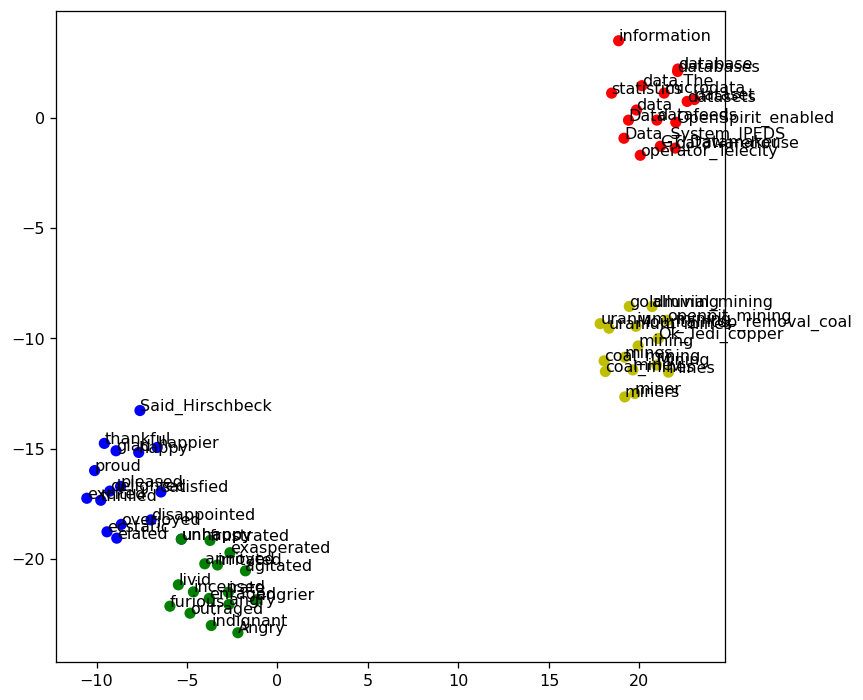

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()